# Tutorial for regression benchmarking

This code loads data and a design matrix, then benchmarks methods of ridge regression in terms of accuracy and speed, both for estimating the alpha(s) and for performing the cross-validated prediction.

Written by Michael Sokoletsky, 2023.


### Imports and options

In [1]:
import time
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from scipy.optimize import fminbound
from tqdm import tqdm

import regbench as rb

opts = {} # Intialize options dictionary
# Recording options
opts['dir'] = 'D:\Churchland\One-photon' # Path to directory in which the recording file is located
opts['rec_name'] = 'miniscope_dataset_LO032_20220923_135753' # Recording name
# opts['dir'] = 'D:\Churchland\Widefield' # Path to directory in which the recording file is located
# opts['rec_name'] = 'mSM63_05-Jul-2018' # Recording name
opts['frames_per_trial'] = 138 # Num of frames per trial
opts['dtype'] = 'neuron_f' # Type of data. Choices: 'wfield_f', 'neuron_f'
# Refression benchmarking options
opts['out_folds'] = 10 # Num of folds for outer (test) cross-validation
opts['in_folds'] = 5 # Num of folds for inner (train) cross-validation
opts['alpha_mets'] = ['Karabastos', 'RidgeCV', 'GridSearchCV', 'fminbound', 'single fminbound', 'None'] # Alpha estimation methods to test
opts['crossval_mets'] = ['Kaufman', 'Ridge', 'cross_val_predict', 'single cross_val_predict'] # Cross-validation methods to test
opts['recenter'] = True # Whether to recenter the variables (no intercept) or not (fit intercept term) for all methods
opts['test_range'] =  np.concatenate([np.arange(1, 2000, 500),
                                      np.arange(3000, 13000,2000),
                                      np.arange(15000, 30000, 5000)]) # Range to test in cross-validated alpha estimation methods
opts['n_jobs'] = -1 # Num of concurrently running workers in cross-validated alpha estimation methods. -1 uses the full CPU capacity.
opts['xtol'] = 100 # Convergence tolerance for the fminbound alpha estimation method
opts['sample_trials'] = -1 # Number of trials to randomally sample for R2 map calculation. -1 uses all of them.

### Load data and design matrix

In [11]:
data = rb.load_data(opts) # Load data/temporal components
data = data - np.mean(data, axis=0) # Center data
design = rb.load_design(opts) # Load design DataFrame
if opts['recenter']:
    design_norm = (design-design.mean())/design.std() # Standardize design DataFrame
else:
    design_norm = design/design.std() # Standardize design DataFrame
out_split, in_split = rb.split_by_trials(data, opts) # Split data into outer and inner folds by trials
calc_score = rb.mint_calc_score(data, opts) # Mint a custom score function 
scorer = make_scorer(calc_score) # Create a scorer based on this scoring function

### Benchmark methods of estimating alphas

In [59]:
alphas = {}
alpha_times = {}
train_idx, _ = out_split[0]
for alpha_met in tqdm(opts['alpha_mets'], desc='Alpha method num'):
    st = time.time()
    if alpha_met == 'Karabastos':
        alphas[alpha_met] = rb.ridge_MML(data[train_idx, :], design_norm.loc[train_idx], regress=False)
    elif alpha_met == 'GridSearchCV':
        mdl = Ridge(fit_intercept=(not opts['recenter']))
        pipeline = Pipeline(steps=[('scalar', StandardScaler()), ('ridge', mdl)])
        mdl = GridSearchCV(pipeline, {'ridge__alpha': opts['test_range']}, cv=in_split, scoring=scorer, n_jobs=opts['n_jobs'], refit=False)
        mdl.fit(design.loc[train_idx], data[train_idx, :])
        alphas[alpha_met] = mdl.best_params_['ridge__alpha']
    elif alpha_met == 'RidgeCV':
        mdl = RidgeCV(alphas=opts['test_range'], scoring='r2', alpha_per_target=True)
        pipeline = make_pipeline(StandardScaler(), mdl)
        pipeline.fit(design.loc[train_idx], data[train_idx, :])
        alphas[alpha_met] = mdl.alpha_
    elif alpha_met == 'fminbound':
        score_func = rb.mint_score_func(design.loc[train_idx], data[train_idx, :], cv=in_split,scoring=scorer, n_jobs=opts['n_jobs'])
        alphas[alpha_met] = fminbound(score_func, opts['test_range'][0], opts['test_range'][-1], xtol=opts['xtol'])
    elif alpha_met == 'single fminbound':
        alphas[alpha_met] = np.zeros(data.shape[1])
        for i in range(data.shape[1]):
            score_func = rb.mint_score_func(design.loc[train_idx], data[train_idx, i], cv=in_split, scoring='r2', n_jobs=opts['n_jobs'])
            alphas[alpha_met][i] = fminbound(score_func, opts['test_range'][0], opts['test_range'][-1], xtol=opts['xtol'])
    elif alpha_met == 'None':
        alphas[alpha_met] = 0
    alpha_times[alpha_met] = time.time() - st

Alpha method num:   0%|          | 0/5 [00:00<?, ?it/s]c:\Users\michaeso.WISMAIN\OneDrive - weizmann.ac.il\Research\Analysis 2.0\regbench-main\regbench\ridge.py:343: RuntimeWarning: divide by zero encountered in log
  NLL_func = lambda L: - (q * np.log(L) - np.sum(np.log(L + d2[:q])) \
Alpha method num: 100%|██████████| 5/5 [01:33<00:00, 18.61s/it]


### Side-analysis: compare 

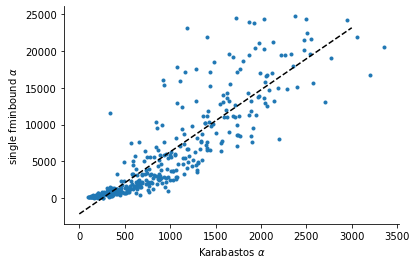

In [67]:
include_idx = np.where(alphas['single fminbound'] <= 24900) # indices past bound

karabastos = alphas['Karabastos'][include_idx]
single_fminbound = alphas['single fminbound'][include_idx]

plt.plot(karabastos, single_fminbound, '.')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.xlabel(r'Karabastos $\alpha$')
plt.ylabel(r'single fminbound $\alpha$')

# Regress the two variables and plot the line
mdl = LinearRegression()
mdl.fit(karabastos.reshape(-1, 1), single_fminbound.reshape(-1, 1))
plt.plot(np.arange(0, 3000, 1), mdl.predict(np.arange(0, 3000, 1).reshape(-1, 1)), 'k--')


### Benchmark methods of cross-validation

In [12]:
preds = {(opt1, opt2): np.zeros_like(data) for opt1, opt2 in itertools.product(opts['crossval_mets'], opts['alpha_mets'])}
scores = {}
avg_scores = {}
pred_times = {}
for crossval_met in opts['crossval_mets']:
    for alpha_met in tqdm(opts['alpha_mets'], desc=f'Testing alphas for {crossval_met} method'):
        st = time.time()
        if crossval_met == 'Kaufman':
            for (train_idx, test_idx) in out_split:
                c_beta = rb.ridge_MML(data[train_idx, :], design_norm.loc[train_idx], L=alphas[alpha_met],
                                    recenter=opts['recenter'])
                if opts['recenter'] == False:
                    preds[crossval_met, alpha_met][test_idx, :] = c_beta[0, :] + design.loc[test_idx] @ c_beta[1:, :]
                else:
                    preds[crossval_met, alpha_met][test_idx, :] = design_norm.loc[test_idx] @ c_beta
        elif crossval_met == 'Ridge':
            mdl = make_pipeline(StandardScaler(), Ridge(alpha=alphas[alpha_met], fit_intercept=False))
            for (train_idx, test_idx) in out_split:
                mdl.fit(design.loc[train_idx], data[train_idx, :])
                preds[crossval_met, alpha_met][test_idx, :] = mdl.predict(design.loc[test_idx])
        elif crossval_met == 'cross_val_predict':
            mdl = make_pipeline(StandardScaler(), Ridge(alpha=alphas[alpha_met], fit_intercept=False))
            preds[crossval_met, alpha_met] = cross_val_predict(mdl, design, data, cv=out_split, n_jobs=opts['n_jobs'])
        elif crossval_met == 'single cross_val_predict':
            preds[crossval_met, alpha_met] = np.zeros_like(data)
            for i in range(data.shape[1]):
                if hasattr(alphas[alpha_met], "__len__"):
                    alpha = alphas[alpha_met][i]
                else:
                    alpha = alphas[alpha_met]
                mdl = make_pipeline(StandardScaler(), Ridge(alpha=alpha, fit_intercept=False))
                preds[crossval_met, alpha_met][:, i] = cross_val_predict(mdl, design, data[:, i], cv=out_split, n_jobs=opts['n_jobs'])
        scores[crossval_met, alpha_met], avg_scores[crossval_met, alpha_met] = calc_score(data, preds[crossval_met, alpha_met])
        pred_times[crossval_met, alpha_met] = time.time() - st + alpha_times[alpha_met]

rb.save_results({'alphas': alphas,
                 'preds': preds,
                 'scores': scores,
                 'avg_scores': avg_scores,
                 'alpha_times': alpha_times,
                 'pred_times': pred_times}, opts)  # Save results

Testing alphas for cross_val_predict method: 100%|██████████| 6/6 [00:02<00:00,  2.33it/s]
Testing alphas for single cross_val_predict method: 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]


### Benchmarking summary plots

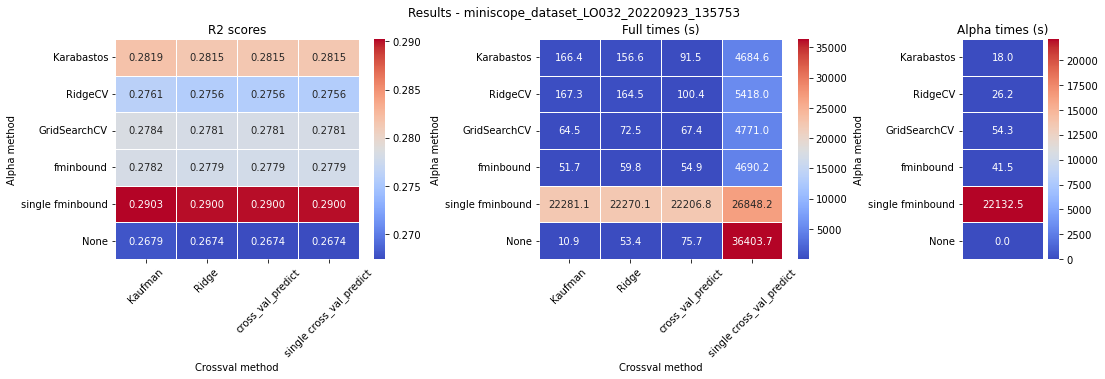

In [13]:
alphas, preds, scores, avg_scores, alpha_times, pred_times = rb.load_results(['alphas', 'preds', 'scores', 'avg_scores', 'alpha_times', 'pred_times'], opts)  # Load results - useful if loading already analyzed sessions

sum_fig, sum_ax = plt.subplots(ncols=3, gridspec_kw={'width_ratios': [3, 3, 1]}, figsize=(17,4.5))
plt.suptitle(f'Results - {opts["rec_name"] }')

scores_df = rb.unstack(pd.Series(avg_scores))
scores_plot = sns.heatmap(scores_df, annot=True, fmt='.4f', cmap="coolwarm", linewidth=.5, ax=sum_ax[0])
scores_plot.set(title='R2 scores', xlabel='Crossval method', ylabel='Alpha method')
scores_plot.set_xticklabels(scores_plot.get_xticklabels(), rotation = 45)

times_df = rb.unstack(pd.Series(pred_times))
times_plot = sns.heatmap(times_df, annot=True, fmt='.1f', cmap="coolwarm", linewidth=.5, ax=sum_ax[1])
times_plot.set(title='Full times (s)', xlabel='Crossval method', ylabel='Alpha method')
times_plot.set_xticklabels(times_plot.get_xticklabels(), rotation = 45)

alpha_times_df = pd.Series(alpha_times).to_frame();
alpha_times_plot = sns.heatmap(alpha_times_df, annot=True, fmt='.1f', cmap="coolwarm", linewidth=.5, ax=sum_ax[2], xticklabels=False)
alpha_times_plot.set(title='Alpha times (s)', ylabel='Alpha method');

plt.subplots_adjust(bottom=0.2, wspace=0.5)
rb.save_fig(sum_fig, opts, name=f'rb_results_{opts["rec_name"]}') # Save plot

### Compute and plot score maps (widefield only)

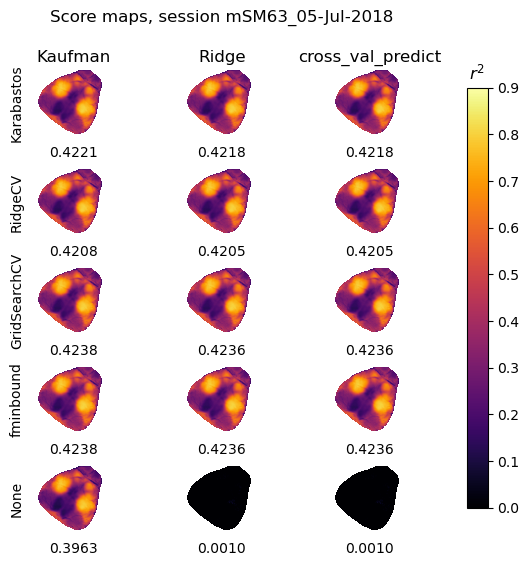

In [22]:
u = rb.load_spat(opts) # load spatial components
maps = {}

for crossval_met in opts['crossval_mets']:
    for alpha_met in tqdm(opts['alpha_mets'], desc=f'Computing maps for {crossval_met} method'):
        maps[crossval_met, alpha_met] = rb.vis_score(data, u, preds[crossval_met, alpha_met], opts)

score_fig, score_ax = plt.subplots(len(opts['alpha_mets']), len(opts['crossval_mets']), figsize=(7, 6))
plt.suptitle(f'Score maps, session {opts["rec_name"]}')

[axi.grid(False) for axi in score_ax.ravel()]
[axi.spines[['bottom', 'left', 'right', 'top']].set_visible(False) for axi in score_ax.ravel()]
[axi.set_xticks([]) for axi in score_ax.ravel()]
[axi.set_yticks([]) for axi in score_ax.ravel()]

plots = {}
for nx, crossval_met in enumerate(opts['crossval_mets']):
    for ny, alpha_met in enumerate(opts['alpha_mets']):
        plots[ny, nx] = score_ax[ny, nx].imshow(maps[crossval_met, alpha_met], cmap='inferno', vmin=0, vmax=0.9)
        score_ax[ny, nx].set_xlabel(f'{np.nanmean(maps[crossval_met, alpha_met]):.4f}')
        if ny == 0: score_ax[ny, nx].set_title(crossval_met)
        if nx == 0: 
            score_ax[ny, nx].set_ylabel(alpha_met)

score_fig.subplots_adjust(left=0.2, right=0.8, hspace=0.5)
cbar_ax = score_fig.add_axes([0.85, 0.15, 0.03, 0.7])
cbar = score_fig.colorbar(plots[0, 0], cax=cbar_ax, orientation='vertical')
cbar_ax.set_title('$r^2$'); 

rb.save_fig(score_fig, opts, name=f'rb_corrs_{opts["rec_name"]}') # Save plot        

#### Compare R2 values across alpha methods (single cells only)

0.418018018018018

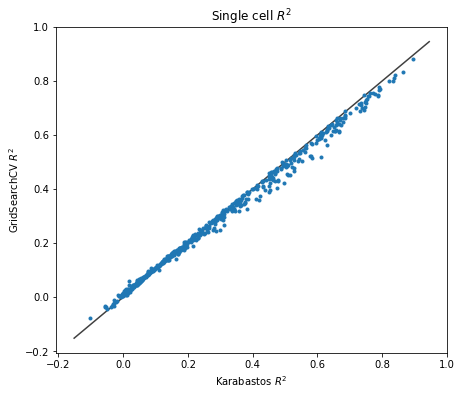

In [15]:
single_met = 'Karabastos'
multi_met = 'GridSearchCV'

comp_fig = plt.figure(figsize=(7, 6))
plt.plot(scores['cross_val_predict', single_met], scores['cross_val_predict', multi_met], '.')
# Plot diagonal line
lims = [np.min([plt.xlim(), plt.ylim()]), np.max([plt.xlim(), plt.ylim()])]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

plt.xlabel(f'{single_met} $R^2$')
plt.ylabel(f'{multi_met} $R^2$')
plt.title(r'Single cell $R^2$')

np.where(scores['cross_val_predict', single_met] > scores['cross_val_predict', multi_met])[0].shape[0] / scores['cross_val_predict', single_met].shape[0]